In [1]:
%load_ext autoreload
%autoreload 2
'''
Example of how to use the library for learning using the PILCO learner on the cartpole task
'''
# pylint: disable=C0103
import atexit
import sys
import os
import numpy as np
import kusanagi.ghost.regression as kreg

from kusanagi import utils
from kusanagi.shell.cartpole import default_params
from kusanagi.ghost.learners.PILCO import PILCO, MC_PILCO
from kusanagi.ghost.control import NNPolicy
from kusanagi.utils import plot_results

#np.random.seed(31337)
np.set_printoptions(linewidth=500)

In [2]:
# setup output directory
utils.set_output_dir(os.path.join(utils.get_output_dir(), 'cartpole'))

use_bnn = True
J = 10                                                       # number of random initial trials
N = 100                                                     #learning iterations
pilco_config = default_params()
# initialize learner params for PILCO
pilco_config['params']['use_empirical_x0'] = True
pilco_config['params']['realtime'] = False
pilco_config['params']['H'] = 4.0
pilco_config['params']['plant']['dt'] = 0.1
pilco_config['params']['plant']['params']['l'] = .6
pilco_config['params']['cost']['pendulum_length'] = .6

# create copy of params for MC-PILCO
mcpilco_config = pilco_config.copy()
mcpilco_config['params']['min_method'] = 'ADAM'
mcpilco_config['params']['learning_rate'] = 1e-3
mcpilco_config['params']['max_evals'] = 1000
mcpilco_config['params']['clip'] = 1.0
mcpilco_config['dynmodel_class'] = kreg.BNN

# init learners
pilco = PILCO(**pilco_config)
mcpilco = MC_PILCO(**mcpilco_config)
mcpilco.resample = True

# share experience and policy between the two learners
mcpilco.experience = pilco.experience
mcpilco.policy = pilco.policy

# gather data with random trials on the pilco learner
for i in range(J):
    pilco.plant.reset_state()
    pilco.apply_controller(random_controls=True)
#pilco.plant.reset_state()
#pilco.apply_controller()

[2017-05-16 17:54:59.098471] RBFPolicy_sat > Initializing parameters
[2017-05-16 17:54:59.105137] RBFPolicy_sat > Initialising expression graph for full GP training loss function
[2017-05-16 17:54:59.242052] RBFPolicy_sat > Initialising expression graph for prediction
[2017-05-16 17:54:59.256738] RBFPolicy_sat > Compiling mean and variance of prediction
[2017-05-16 17:54:59.705502] RBFPolicy_sat > Done compiling
[2017-05-16 17:54:59.716188] Experience > Initialising new experience dataset
[2017-05-16 17:54:59.717144] PILCO > Initialising new PILCO learner
[2017-05-16 17:54:59.719285] RBFPolicy_sat > Initializing parameters
[2017-05-16 17:54:59.722488] RBFPolicy_sat > Initialising expression graph for full GP training loss function
[2017-05-16 17:54:59.898085] RBFPolicy_sat > Initialising expression graph for prediction
[2017-05-16 17:54:59.913086] RBFPolicy_sat > Compiling mean and variance of prediction
[2017-05-16 17:55:00.032189] RBFPolicy_sat > Done compiling
[2017-05-16 17:55:00.0

In [3]:
pilco.train_dynamics()

[2017-05-16 17:55:02.375615] PILCO > Training dynamics model
[2017-05-16 17:55:02.376729] GP_UI > Unable to load state from /home/juancamilog/.kusanagi/output/cartpole/PILCO_GP_UI_6_4_Cartpole_RBFPolicy_sat_dynamics.zip
[2017-05-16 17:55:02.379222] GP_UI > Initialising parameters
[2017-05-16 17:55:02.380622] PILCO > Dataset size:: Inputs: [ (400, 6) ], Targets: [ (400, 4) ]  
[2017-05-16 17:55:02.381595] GP_UI > Initialising expression graph for full GP training loss function
[2017-05-16 17:55:02.565234] GP_UI > Compiling full GP training loss function
[2017-05-16 17:55:02.661244] GP_UI > Compiling gradient of full GP training loss function
[2017-05-16 17:55:02.977854] GP_UI > Current hyperparameters:
[array([[ 0.07404404, -0.06757079,  0.7474938 , -1.10895681, -1.60121682,  1.09235848, -2.37452335, -4.67710845],
       [ 0.07404404, -0.06757079,  0.7474938 , -1.10895681, -1.60121682,  1.09235848, -0.84241192, -3.14499701],
       [ 0.07404404, -0.06757079,  0.7474938 , -1.10895681, -1

In [4]:
mcpilco.train_dynamics()

[2017-05-16 17:55:08.871365] MC_PILCO > Training dynamics model
[2017-05-16 17:55:08.875299] BNN > Unable to load state from /home/juancamilog/.kusanagi/output/cartpole/MC_PILCO_BNN_6_4_Cartpole_RBFPolicy_sat_dynamics.zip
[2017-05-16 17:55:08.883062] MC_PILCO > Dataset size:: Inputs: [ (400, 6) ], Targets: [ (400, 4) ]  
[2017-05-16 17:55:08.885792] BNN > Building network
InputLayer {'shape': (None, 6), 'name': 'BNN_input'}
DenseLayer {'num_units': 400, 'nonlinearity': <function sigmoid at 0x7fee1e92a8c8>, 'name': 'BNN_fc0'}
DropoutLayer {'p': 0.25, 'rescale': False, 'name': 'BNN_drop0', 'dropout_samples': array(10, dtype=int32)}
DenseLayer {'num_units': 400, 'nonlinearity': <function sigmoid at 0x7fee1e92a8c8>, 'name': 'BNN_fc1'}
DropoutLayer {'p': 0.25, 'rescale': False, 'name': 'BNN_drop1', 'dropout_samples': array(10, dtype=int32)}
DenseLayer {'num_units': 4, 'nonlinearity': <function linear at 0x7fee1e8c51e0>, 'name': 'BNN_output'}
[2017-05-16 17:55:08.905393] BNN > Initialising l

In [5]:
for episode_states,episode_actions in zip(np.array(pilco.experience.states),pilco.experience.actions):
    mcp_preds = []
    p_preds = []
    for state, action in zip(episode_states, episode_actions):
        st = utils.gTrig_np(state, pilco.angle_idims).squeeze()
        inp = np.concatenate((st,action))
        p_preds.append( pilco.dynamics_model.predict( inp, np.zeros( (inp.size, inp.size) ) ) )
        mcp_preds.append( mcpilco.dynamics_model.predict(inp) )

[2017-05-16 17:56:19.700454] GP_UI > Initialising expression graph for prediction
[2017-05-16 17:56:19.787159] GP_UI > Compiling mean and variance of prediction
[2017-05-16 17:56:20.166560] GP_UI > Done compiling
[2017-05-16 17:56:20.219811] BNN > Initialising expression graph for prediction
[2017-05-16 17:56:20.332662] BNN > Compiling mean and variance of prediction
[2017-05-16 17:56:20.387099] BNN > Done compiling


[2017-05-16 17:56:32.711719] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-16 17:56:33.124594] MC_PILCO > Compiling trajectory rollout function
[2017-05-16 17:56:33.495710] MC_PILCO > Done compiling.


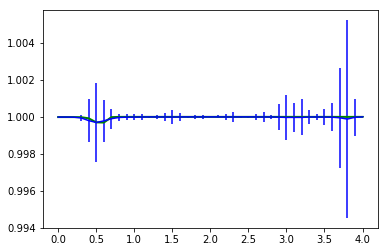

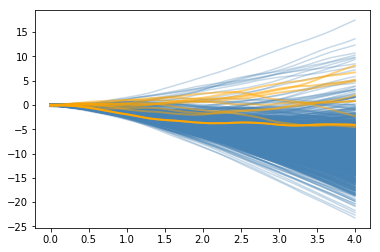

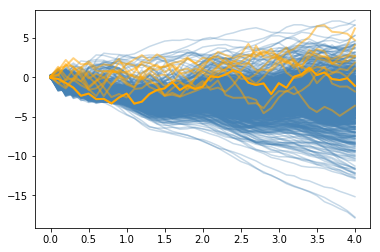

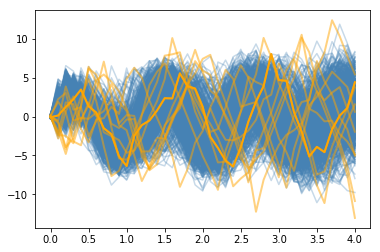

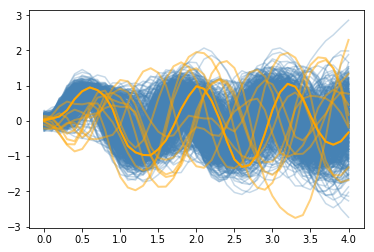

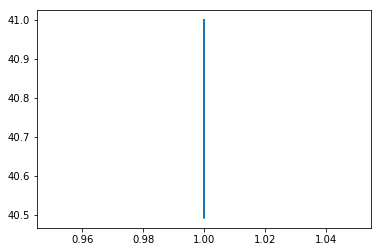

In [6]:
mcpilco.resample = False
mcpilco.rollout_fn = None
mcpilco.set_n_samples(1000)
plot_results(mcpilco)

[2017-05-16 17:56:57.318337] PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-16 17:56:57.855548] PILCO > Compiling belief state propagation
[2017-05-16 17:56:59.208864] PILCO > Done compiling.
[2017-05-16 17:57:00.421145] plot_results > Predicted value: [40.999193]


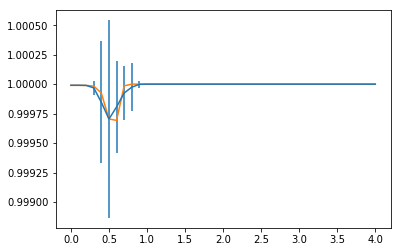

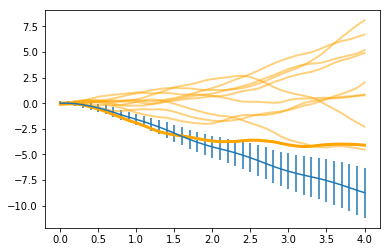

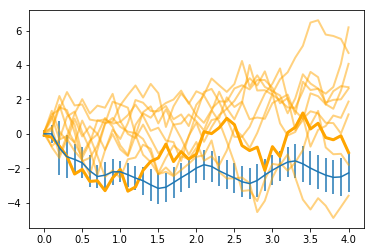

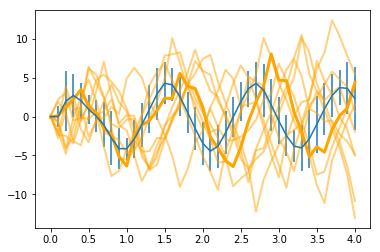

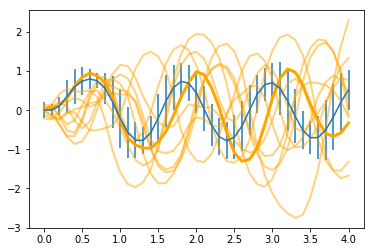

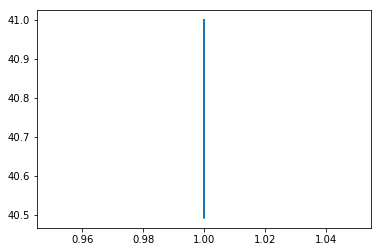

In [7]:
plot_results(pilco)

In [5]:
pilco.experience.n_episodes()

5

In [7]:
X,Y = mcpilco.experience.get_dynmodel_dataset()
nn = kreg.BNN(idims=X.shape[-1],odims=Y.shape[-1])
nn.append_dataset(X,Y)

[2017-05-16 17:40:31.496990] BNN > BaseRegressor append dataset
setting dataset
(200, 5)
None


TypeError: super(type, obj): obj must be an instance or subtype of type